# Optimization of E. coli growth parameters for NUFEB
This notebook utilizes hyperparameter optimization to fit simulated E. coli growth curves to experimental data. Under the hood, we use scikit-optimize to perform a Bayesian optimization.

In [1]:
#Imports
import os
from random import uniform
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel,delayed
import joblib
import subprocess
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize,load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective,plot_gaussian_process
from scipy.optimize import curve_fit
from scipy import interpolate
from skopt import Optimizer
from skopt.space import Real
import shutil


In [17]:
expPath = r'/home/jonathan/nufeb-cyano-e-coli/experimental-data/ecw-growth-R2.xlsx'
growthData = pd.read_excel(expPath,sheet_name='Growth')
expSucrose =pd.read_excel(expPath,sheet_name='Sucrose')

In [18]:
growthData = growthData.loc[growthData['Initial Sucrose'] !=20]
growthData=growthData.groupby(['Time','Initial Sucrose']).mean().reset_index()[['Time','Initial Sucrose','OD600']]
growthData.head()


,Time,Initial Sucrose,OD600
0,0,2,0.010000
1,0,5,0.010000
2,0,10,0.010000
3,1,2,0.010000
4,1,5,0.016333


In [19]:
expSucrose = expSucrose.loc[expSucrose['Initial Sucrose'] !=20]
expSucrose = expSucrose.groupby(['Time','Initial Sucrose']).mean().reset_index()[['Time','Initial Sucrose','Sucrose']]
expSucrose.head()

,Time,Initial Sucrose,Sucrose
0,0,2,1.855295
1,0,5,4.685920
2,0,10,9.489184
3,4,2,1.808598
4,4,5,4.631757


In [20]:
growthData10 = growthData.loc[(growthData['Initial Sucrose']==10) & (growthData.Time < 15)]
expSucrose10 = expSucrose.loc[(expSucrose['Initial Sucrose']==10) & (expSucrose.Time < 15)]

In [21]:
    SucroseMW = 342.3
suc = expSucrose.loc[(expSucrose.Time ==0) & (expSucrose['Initial Sucrose']==10)].Sucrose.values[0]*1e3/SucroseMW
print(suc)

27.72183540345684


# Optimization function
## Parameters to optimize:
### $\mu_{max}$ (Monod-based growth rate, $s^{-1}$)
### $\rho$ (Cell density, $\frac{kg}{m^3}$)
### $k_{sucrose}$ (Sucrose uptake half-maximum, $\frac{kg}{m^3}$)
### m (Cellular maintenance cost, $s^{-1}$)

In [22]:
#Volume = 1e-4*1e-4*1e-4 #m^3
#mlm3 = 1e6 #mL/m^3
#Biomass2OD = Volume*.44


In [23]:
def mu_func(x,K,r,N0):
    return K/(1  + ((K-N0)/N0)*np.exp(-r*x))

In [24]:
def run_sim(folder):
    os.chdir(folder)
    in_path = folder / 'Inputscript.lammps'
    try:
        os.system(f'mpirun -np 1 /home/jonathan/NUFEB/lammps/src/lmp_png -in {in_path} > nufeb.log')
        #subprocess.run(['mpirun', '-np', '4','/home/jsakkos/NUFEB/lammps/src/lmp_png','-in', '*.lammps > nufeb.log'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        #os.chdir(r'/home/jsakkos/NUFEB')
        return folder
    except:
        print('Something went wrong')
def collect_data(folder):
    SucroseMW = 342.3
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    Biomass2OD = .44*Volume*1e18
    temp = pd.concat([x.biomass.ecw.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD600','Hours','Sucrose']
    temp['Sucrose']=temp['Sucrose']*SucroseMW*1e-3
    temp['S0'] = temp.Sucrose.iloc[0]
    return temp
def run_collect(folder):
    os.chdir(folder)
    in_path = folder / 'Inputscript.lammps'
    os.system(f'mpirun -np 1 /home/jonathan/NUFEB/lammps/src/lmp_png -in {in_path} > nufeb.log')
    SucroseMW = 342.3
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    Biomass2OD = .44*Volume*1e18
    temp = pd.concat([x.biomass.ecw.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD600','Hours','Sucrose']
    temp['Sucrose']=temp['Sucrose']*SucroseMW*1e-3
    temp['S0'] = temp.Sucrose.iloc[0]
    return temp
def test(x,growth=growthData10,sucrose=expSucrose10):
   
    mu = x[0]
    rho = x[1]
    ksuc = x[2]
    #yield_ = x[3]
    maint = 0#x[3]
    SucroseMW = 342.3
    os.chdir('/home/jonathan/NUFEB')
    SucroseMW = 342.3
    rng = str(np.random.randint(0,1e6,1)[0])
    os.mkdir(rng)
    os.chdir(rng)
    dir_path = Path(os.getcwd()).resolve()
    text = f'nufeb-seed --n 1 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 100 --t 4700 --suc 27.72 --muecw {mu}  --rhoecw {rho} --ksuc {ksuc} --maintecw {maint} --yieldecw .5 --niter 1000000 --mass 7e-12 --biodt 1 --suc_halt True'
    os.system(text)
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
    #tmp=Parallel(n_jobs=-1)(delayed(run_collect)(folder) for folder in folders)
    #data = pd.concat(tmp,ignore_index=True)
    data = run_collect(folders[0])
    #data=pd.concat((futures[i].result() for i in range(3)),ignore_index=True) 
    df = data.groupby(['Hours','S0']).mean().reset_index()
    df.loc[df.S0==10]
    g=interpolate.interp1d(df.Hours,df.OD600,fill_value='extrapolate')
    rmse = mean_squared_error(growth.OD600, g(growth.Time), sample_weight=growth.OD600,squared = False)
    r2g = r2_score(growth.OD600, g(growth.Time))
    suc=interpolate.interp1d(df.Hours,df.Sucrose,fill_value='extrapolate')
    rmse += mean_squared_error(sucrose.Sucrose, suc(sucrose.Time), sample_weight=sucrose.Sucrose,squared = False)
    r2s = r2_score(sucrose.Sucrose, suc(sucrose.Time))
    # f, axes = plt.subplots(ncols=2)
    # sns.scatterplot(x='Time',y='OD600',data=growth,ax=axes[0])
    # sns.scatterplot(x='Time',y='Sucrose',data=sucrose,ax=axes[1])
    # sns.lineplot(x='Hours',y='OD600',hue='S0',data=df,ax=axes[0])
    # sns.lineplot(x='Hours',y='Sucrose',hue='S0',data=df,ax=axes[1])
    # #plot
    # sns.despine()
    # plt.show()
    print(f'R2 = {r2g:.3f} (growth),{r2s:.3f} (sucrose)')
    os.chdir('/home/jonathan/NUFEB')
    try:
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))
    return rmse


In [25]:
# os.chdir('/home/jonathan/NUFEB')
# os.system('nufeb-clean')
# SucroseMW = 342.3
# for s in growthData['Initial Sucrose'].unique():
#     suc = s*1e3/SucroseMW
#     text = f'nufeb-seed --n 1 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --suc {suc:.2f} --muecw 4e-4  --rhoecw 250 --ksuc .1 --maintecw 0 --niter 1000000 --mass 1e-11 --yieldecw 0.43 --biodt 10'
#     os.system(text)
# BASE_DIR = Path(f'runs/')
# folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
# futures =client.map(run_collect,folders)
# wait(futures,return_when='ALL_COMPLETED')
# data=pd.concat((futures[i].result() for i in range(3)),ignore_index=True) 
# #data=dd.concat((futures[i].result() for i in range(3)),ignore_index=True) 
# df = data.groupby(['Hours','S0']).mean().reset_index()
# f, axes = plt.subplots(ncols=2)
# sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=growthData,ax=axes[0])
# sns.scatterplot(x='Time',y='Sucrose',hue='Initial Sucrose',data=expSucrose,ax=axes[1])
# sns.lineplot(x='Hours',y='OD600',hue='S0',data=df,ax=axes[0])
# sns.lineplot(x='Hours',y='Sucrose',hue='S0',data=df,ax=axes[1])
# sns.despine()
# plt.show()
# rmse = 0
# r2g=0
# r2s=0
# for s in growthData['Initial Sucrose'].unique():
#     temp = growthData.loc[growthData['Initial Sucrose']==s]
#     sim_temp = df.loc[df.S0==s]
#     g=interpolate.interp1d(sim_temp.Hours,sim_temp.OD600)
#     rmse += mean_squared_error(temp.OD600, g(temp.Time), sample_weight=temp.OD600,squared = False)
#     r2g += r2_score(temp.OD600, g(temp.Time))
#     temp2 = expSucrose.loc[expSucrose['Initial Sucrose']==s]
#     suc=interpolate.interp1d(sim_temp.Hours,sim_temp.Sucrose)
#     rmse += mean_squared_error(temp2.Sucrose, suc(temp2.Time), sample_weight=temp2.Sucrose,squared = False)
#     r2s += r2_score(temp2.Sucrose, suc(temp2.Time))
#     r2g=r2g/len(growthData['Initial Sucrose'].unique())
#     r2s=r2s/len(growthData['Initial Sucrose'].unique())

# print(f'R2 = {r2g:.3f} (growth),{r2s:.3f} (sucrose)')

In [26]:
# sns.scatterplot(x='Hours',y='OD600',data=df.loc[df.S0==10])
# sns.scatterplot(x='Time',y='OD600',data=growthData.loc[growthData['Initial Sucrose']==10])

In [27]:
# sns.scatterplot(x='Hours',y='Sucrose',data=df.loc[df.S0==10])
# sns.scatterplot(x='Time',y='Sucrose',data=expSucrose.loc[expSucrose['Initial Sucrose']==10])

In [28]:
# temp = growthData.loc[growthData['Initial Sucrose']==10]
# sim_temp = df.loc[df.S0==10]
# g=interpolate.interp1d(sim_temp.Hours,sim_temp.OD600)
# rmse += mean_squared_error(temp.OD600, g(temp.Time), sample_weight=temp.OD600,squared = False)
# r2g += r2_score(temp.OD600, g(temp.Time))
# temp2 = expSucrose.loc[expSucrose['Initial Sucrose']==10]
# suc=interpolate.interp1d(sim_temp.Hours,sim_temp.Sucrose)
# rmse += mean_squared_error(temp2.Sucrose, suc(temp2.Time), sample_weight=temp2.Sucrose,squared = False)
# r2s += r2_score(temp2.Sucrose, suc(temp2.Time))
# r2g=r2g/len(growthData['Initial Sucrose'].unique())
# r2s=r2s/len(growthData['Initial Sucrose'].unique())

# print(f'R2 = {r2g:.3f} (growth),{r2s:.3f} (sucrose)')

In [40]:
def check_result(x,growth=growthData10,sucrose=expSucrose10):
   
    mu = x[0]
    rho = x[1]
    ksuc = x[2]
    #yield_ = x[3]
    maint = 0#x[3]
    print(f'mu: {mu:.3e},rho: {rho:.3e},ksuc: {ksuc:.3e}')
    SucroseMW = 342.3
    os.chdir('/home/jonathan/NUFEB')
    SucroseMW = 342.3
    rng = str(np.random.randint(0,1e6,1)[0])
    os.mkdir(rng)
    os.chdir(rng)
    dir_path = Path(os.getcwd()).resolve()
    text = f'nufeb-seed --n 1 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 100 --t 4700 --suc 27.72 --muecw {mu}  --rhoecw {rho} --ksuc {ksuc} --maintecw {maint} --yieldecw .5 --niter 1000000 --mass 7e-12 --biodt 1 --suc_halt True'
    os.system(text)
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
    #tmp=Parallel(n_jobs=-1)(delayed(run_collect)(folder) for folder in folders)
    data = run_collect(folders[0])
    #data=pd.concat((futures[i].result() for i in range(3)),ignore_index=True) 
    df = data.groupby(['Hours','S0']).mean().reset_index()
    df.loc[df.S0==10]
    g=interpolate.interp1d(df.Hours,df.OD600,fill_value='extrapolate')
    rmse = mean_squared_error(growth.OD600, g(growth.Time), sample_weight=growth.OD600,squared = False)
    r2g = r2_score(growth.OD600, g(growth.Time))
    suc=interpolate.interp1d(df.Hours,df.Sucrose,fill_value='extrapolate')
    rmse += mean_squared_error(sucrose.Sucrose, suc(sucrose.Time), sample_weight=sucrose.Sucrose,squared = False)
    r2s = r2_score(sucrose.Sucrose, suc(sucrose.Time))
    f, axes = plt.subplots(ncols=2)
    sns.scatterplot(x='Time',y='OD600',data=growth,ax=axes[0],label='Experimental')
    sns.scatterplot(x='Time',y='Sucrose',data=sucrose,ax=axes[1],label='Experimental')
    axes[0].plot(df.Hours,df.OD600,color='red',label='Simulated')
    axes[1].plot(df.Hours,df.Sucrose,color='red',label='Simulated')
    #sns.lineplot(x='Hours',y='OD600',data=df,ax=axes[0],palette='Reds',label='Simulated')
    #sns.lineplot(x='Hours',y='Sucrose',data=df,ax=axes[1],palette='Reds',label='Simulated')
    #plot
    sns.despine()
    plt.show()
    print(f'R2 = {r2g:.3f} (growth),{r2s:.3f} (sucrose)')
    os.chdir('/home/jonathan/NUFEB')
    try:
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))
    return rmse



In [30]:

optimizer = Optimizer(
    dimensions=[Real(float('5e-5'), float('8e-4')), 
                Real(180, 307),
                Real(float('1e-1'),float('1e1'))],
    random_state=1,
    base_estimator='gp'
)


for i in tqdm(range(5)):
    x = optimizer.ask(n_points=8)  # x is a list of n_points points
    y = Parallel(n_jobs=8)(delayed(test)(v) for v in x)  # evaluate points in parallel
    optimizer.tell(x, y)
print(min(optimizer.yi)) # print the best objective found

  0%|                                                                                                                                     | 0/5 [00:00<?, ?it/s]

R2 = -0.860 (growth),-1.016 (sucrose)
R2 = -0.851 (growth),-1.001 (sucrose)
R2 = -0.825 (growth),-0.959 (sucrose)
R2 = -0.802 (growth),-0.921 (sucrose)


 20%|████████████████████████▊                                                                                                   | 1/5 [14:12<56:50, 852.74s/it]

R2 = -0.058 (growth),-0.982 (sucrose)
R2 = 0.970 (growth),0.641 (sucrose)
R2 = -0.027 (growth),-1.296 (sucrose)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:38:06<00:00, 1177.36s/it]

1.279901829415012


R2 = 0.129 (growth),-0.964 (sucrose)
R2 = 0.930 (growth),0.949 (sucrose)
R2 = 0.860 (growth),0.200 (sucrose)
R2 = 0.986 (growth),0.894 (sucrose)
R2 = 0.768 (growth),0.952 (sucrose)
R2 = 0.942 (growth),0.945 (sucrose)
R2 = 0.994 (growth),0.799 (sucrose)
R2 = 0.984 (growth),0.898 (sucrose)
R2 = 0.470 (growth),-0.509 (sucrose)
R2 = 0.936 (growth),0.948 (sucrose)
R2 = 0.840 (growth),0.199 (sucrose)
R2 = 0.989 (growth),0.892 (sucrose)
R2 = 0.682 (growth),-0.012 (sucrose)
R2 = 0.993 (growth),0.851 (sucrose)
R2 = 0.939 (growth),0.947 (sucrose)
R2 = 0.826 (growth),0.197 (sucrose)
R2 = 0.989 (growth),0.891 (sucrose)
R2 = 0.489 (growth),-0.434 (sucrose)
R2 = 0.988 (growth),0.890 (sucrose)
R2 = 0.994 (growth),0.860 (sucrose)
R2 = 0.995 (growth),0.800 (sucrose)
R2 = 0.977 (growth),0.905 (sucrose)
R2 = 0.977 (growth),0.880 (sucrose)
R2 = 0.510 (growth),0.803 (sucrose)
R2 = 0.994 (growth),0.854 (sucrose)
R2 = 0.854 (growth),0.198 (sucrose)
R2 = 0.988 (growth),0.893 (sucrose)
R2 = 0.994 (growth),0.85

In [31]:
optimizer.get_result()

          fun: 1.279901829415012
    func_vals: array([ 6.89544063, 11.75488191, 11.84494324,  1.72683802, 11.87543998,
       11.67569918,  5.69380691,  2.73254243,  8.57928805,  5.60808474,
        1.34133646,  1.35007044,  8.30359712,  3.55833368,  7.00898691,
        8.091759  ,  1.38191057,  1.81645861,  1.97472896,  1.34799014,
        1.89822353,  1.83725094,  1.49380827,  1.40690828,  4.6027086 ,
        1.61469999,  4.70546909,  4.87837621,  4.87147675,  4.80148947,
        1.62651148,  4.68379311,  1.39436328,  1.39508116,  1.27990183,
        1.38235535,  1.28083325,  1.31408895,  1.42837848,  1.56542153])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1791095845), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
       

In [32]:
optimizer.get_result().x

[0.0005364796780378654, 279.82515011646757, 10.0]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

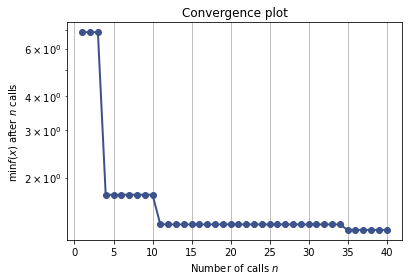

In [33]:
plot_convergence(optimizer.get_result(),yscale='log')

array([[<AxesSubplot:xlabel='$\\mu$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$\\rho$'>,
        <AxesSubplot:xlabel='$\\rho$', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='$\\mu$', ylabel='$K_{sucrose}$'>,
        <AxesSubplot:xlabel='$\\rho$'>,
        <AxesSubplot:xlabel='$K_{sucrose}$', ylabel='Partial dependence'>]],
      dtype=object)

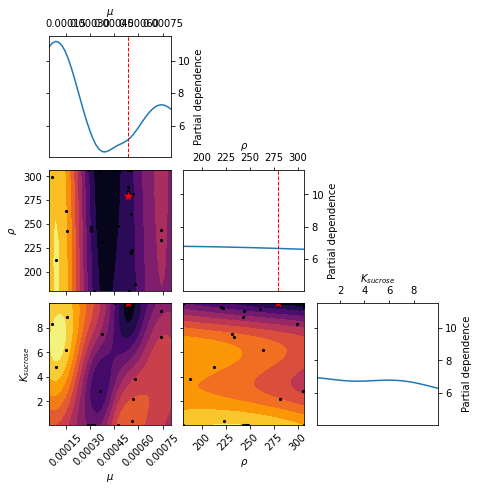

In [35]:
plot_objective(optimizer.get_result(),dimensions=[r'$\mu$',r'$\rho$',r'$K_{sucrose}$'],cmap='inferno')

mu: 5.365e-04,rho: 2.798e+02,ksuc: 1.000e+01


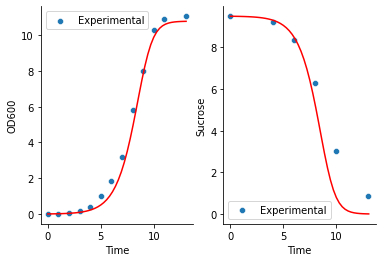

R2 = 0.989 (growth),0.891 (sucrose)


1.27926669015441

In [41]:
check_result(optimizer.get_result().x)